Please adhere to a clear and repeatable folder structure. All file location assumptions in `uavgeo` are based on the following structure:

```
- data/
    - rgb/
        - sfm/
            - dem.tif
            - dtm.tif
            - ortho.tif
            - etc.tif
        - raw/
            - 0001.jpg
            - 0002.jpg
        - other/
            - path.geojson
            - etc.shp 
    - ms/
        - sfm/ 
            - dem.tif
            - dtm.tif
            - ortho.tif
            - etc.
        - raw/
            - 0001.jpg
            - 0002.jpg
        - other/
            - path.geojson
            - etc.shp
```

When working with training the yolov8 model using the `ultralytics` library, the structure is assumed to be the following:
```
- data/
    - yolov8/
        - train
            - images
                - 00001.jpg
                - 00002.jpg
            - labels
                - 00001.txt
                - 00002.txt 
        - test
            - images
                - 00001.jpg
                - 00002.jpg 
            - labels
                - 00001.txt
                - 00002.txt 
        - val
            - images
                - 00001.jpg
                - 00002.jpg 
            - labels
                - 00001.txt
                - 00002.txt 
        - model
            - yolo_best.pth
            - config.yaml
```
Keep this in mind as you make use of various import and export functions in `uavgeo`.


In [ ]:
#using the data download function:
import uavgeo as ug

#downloads by default into relative path from notebook to: "data"
file = ug.load.download("https://zenodo.org/record/8123870/files/ORTHOMOSAIC_230421.jpg", filename = "rgb_ortho.jpg", redownload=True)


# Adhering to the above file structure:
file = ug.load.download("https://zenodo.org/record/8123870/files/ORTHOMOSAIC_230421.jpg", output_dir = "data/rgb/sfm" filename = "ortho.jpg", redownload=True)


In [1]:
#importing sfm result files
import uavgeo as ug
ortho = ug.load.load_sfm(path_to_file = "data/ms/sfm/ortho.tif", xr_name = "ms_ortho")
dem = ug.load.load_sfm(path_to_file = "data/ms/sfm/dem.tif", xr_name = "dem")
dtm = ug.load.load_sfm(path_to_file = "data/ms/sfm/dtm.tif", xr_name = "dtm")


In [1]:
#Sensors based 
def band_selector(device:str):

    implemented = ["micasense-altum-pt", 
                   "dji-multi3",
                   "micasense-rededge-p", 
                   "tetracam-mca6",
                   "parrot-sequoia", 
                   "slantrange-4p",
                   "slantrange-3p" ]

    if device == "micasense-altum-pt": 

        bands = {"blue":{475:32},"green":{560:27}, "red":{668:14}, "rededge":{717:12}, "nir":{842:57}}

    elif device == "dji-multi3":

        bands = {"green":{560:16}, "red":{650:16}, "rededge":{730:16}, "nir":{860:26}}
    
    elif device == "micasense-rededge-p":

        bands = {"blue":{475:32},"green":{560:27}, "red":{668:14}, "rededge":{717:12}, "nir":{842:57}}
    
    elif device == "tetracam-mca6":

        bands = {"blue":{490:10}, "green":{550:10}, "red":{680:10}, "rededge":{720:20}, "nir1":{800:20},"nir2":{900:20}}
    
    elif device == "parrot-sequoia":

        bands = {"green":{550:40}, "red":{660:40}, "rededge":{735:10}, "nir":{790:40}}

    elif device == "slantrange-4p":

        bands = {"blue_rgb": {470:120}, "green_rgb":{550:100}, "red_rgb":{620:110}, "red":{650:40}, "rededge":{710:20}, "nir":{850:100}}

    elif device =="slantrange-3p":

        bands = {"green":{550:40}, "red":{650:40}, "rededge":{710:20}, "nir": {850:100}}

    else:
        raise NotImplementedError("{} is not yet implemented. Please select from: {}".format(device, implemented))

    return bands

def geo_bands_to_colour(bands):
    l = list(bands)
    d= {}

    for item in l:
        for key in bands[item]:
            d[key]=bands[item][key]
            
    return d

In [14]:
import numpy as np

def sum(a, b):
    return a + b

def zipper(a, b, f):
    return np.array([f(ai, bi) for ai, bi in zip(a, b)])

def mapConst(arr, c, f):
    return np.array([f(ai, c) for i, ai in enumerate(arr)])

def dotSS(a, b):
    return a * b

dotVS = lambda v, s: mapConst(v, s, dotSS)

def dotVV(a, b):
    return np.sum(zipper(a, b, dotSS))

def dotMV(A, v):
    return mapConst(A, v, dotVV)

adj = lambda C: 12.92 * C if C < 0.0031308 else 1.055 * pow(C, 0.41666) - 0.055

labF = lambda t: pow(t, 1.0/3.0) if t > 0.00885645 else 0.137931 + 7.787 * t

invLabF = lambda t: t*t*t if t > 0.2069 else 0.12842 * (t - 0.137931)

def XYZ_to_Lab(XYZ):
    lfY = labF(XYZ[1])
    return np.array([(116.0 * lfY - 16)/100,
                     5 * (labF(XYZ[0]) - lfY),
                     2 * (lfY - labF(XYZ[2]))])

def Lab_to_XYZ(Lab):
    YL = (100 * Lab[0] + 16) / 116
    return np.array([invLabF(YL + Lab[1] / 5.0),
                     invLabF(YL),
                     invLabF(YL - Lab[2] / 2.0)])

def XYZ_to_sRGBlin(xyz):
    T = np.array([[3.240, -1.537, -0.499],
                  [-0.969, 1.876, 0.042],
                  [0.056, -0.204, 1.057]])
    return dotMV(T, xyz)

XYZ_to_sRGB = lambda xyz: np.array(list(map(adj, XYZ_to_sRGBlin(xyz))))

def Lab_to_sRGB(Lab):
    return XYZ_to_sRGB(Lab_to_XYZ(Lab))

def getSolarIrr():
    return [B02,B03, B04]

def S2_to_XYZ(rad, T, gain):
    return dotVS(dotMV(T, rad), gain)

def ProperGamma_S2_to_sRGB(rad,gg,gamma,gL):

    T = np.array([[0.268, 0.361, 0.371],
              [0.240, 0.587, 0.174],
              [1.463, -0.427, -0.043]])

    XYZ = S2_to_XYZ(rad, T, gg)
    Lab = XYZ_to_Lab(XYZ)
    L = np.power(gL * Lab[0], gamma)
    return Lab_to_sRGB([L, Lab[1], Lab[2]])


B02 = 0.5  # Replace with actual value
B03 = 0.6  # Replace with actual value
B04 = 0.7  # Replace with actual value






In [2]:
def scale_to_uint8(arr):
    arr = (arr// 256).astype(np.uint8)
    return arr

def scale_to_01(arr):
    arr = arr.astype(np.float16)/255
    return arr

In [3]:
import rioxarray as rx
import numpy as np
xr_name = "ms_ortho"

path_to_file = "data/rgb/sfm/ortho.tif"

ortho = rx.open_rasterio(path_to_file, default_name = xr_name)


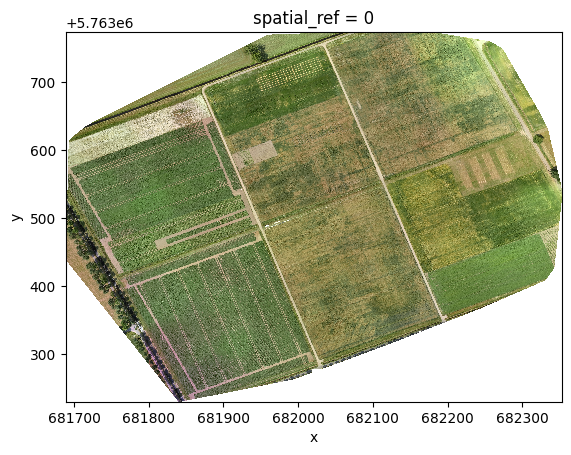

In [22]:
ortho.plot.imshow()

In [4]:
rgb = ortho.sel(band = [1,2,3]).astype(np.uint16)
#rgb = scale_to_uint8(rgb)
rgb = rgb.where(rgb!=0)
rgb = rgb.where(rgb!=65535)
r = rgb.sel(band=1)
g = rgb.sel(band=2)
b = rgb.sel(band=3)

In [6]:
import zen3geo
import uavgeo as ug
dp_ortho = ug.datapipes.start_pipe(iterable = [ortho])
dp_ortho = dp_ortho.slice_with_xbatcher(input_dims = {"x":1024, "y":1024})


In [7]:
raster = list(dp_ortho)[165]

In [8]:
rgb = raster.sel(band = [1,2,3])
rgb = scale_to_01(rgb)

In [9]:
reshaped = rgb.values.reshape(-1,3)

In [36]:
import numpy as np
import xarray as xr


"""
Mostly taken from the following GitHub and paper:
https://github.com/sentinel-hub/natural-color
B. Sovdat, M. Kadunc, M. Batič, G. Milčinski, Natural color representation of Sentinel-2 data.
And converted to JS to Python code using chatGPT
Can probably be optimized a bunch, based on usig more numpy functions.
"""

def zipper(a, b, f):
    """
    Applies the function `f` element-wise to the corresponding elements of arrays `a` and `b`, and returns the result as a NumPy array.

    Parameters:
        a (array-like): First input array.
        b (array-like): Second input array.
        f (callable): Function to be applied to each pair of elements from `a` and `b`.

    Returns:
        ndarray: NumPy array containing the results of applying `f` to each pair of elements from `a` and `b`.
    """
    f_vec = np.vectorize(f)
    return f_vec(a, b)

def mapConst(arr, c, f):
    """
    Applies the function `f` to each element of array `arr` along with a constant `c`, and returns the result as a NumPy array.

    Parameters:
        arr (array-like): Input array.
        c (numeric): Constant value.
        f (callable): Function to be applied to each element of `arr` along with `c`.

    Returns:
        ndarray: NumPy array containing the results of applying `f` to each element of `arr` along with `c`.
    """
    f_vec = np.vectorize(f)
    return f_vec(arr, c)

def dotSS(a, b):
    """
    Computes the element-wise multiplication of two input values.

    Parameters:
        a (numeric): First input value.
        b (numeric): Second input value.

    Returns:
        numeric: Element-wise product of `a` and `b`.
    """
    return a * b

def dotVS(v, s):
    """
    Computes the element-wise multiplication of an input array `v` with a scalar `s`.

    Parameters:
        v (array-like): Input array.
        s (numeric): Scalar value.

    Returns:
        ndarray: NumPy array containing the element-wise product of `v` and `s`.
    """
    return mapConst(v, s, dotSS)

def dotVV(a, b):
    """
    Computes the dot product of two input arrays `a` and `b` by applying `dotSS` element-wise using `zipper`, and then summing the resulting array.

    Parameters:
        a (array-like): First input array.
        b (array-like): Second input array.

    Returns:
        numeric: Dot product of `a` and `b`.
    """
    return np.sum(zipper(a, b, dotSS))

def dotMV(A, v):
    """
    Computes the matrix-vector product of input matrix `A` and input vector `v` using `dotVV` and `mapConst`.

    Parameters:
        A (array-like): Input matrix.
        v (array-like): Input vector.

    Returns:
        ndarray: NumPy array representing the matrix-vector product of `A` and `v`.
    """
    return mapConst(A, v, dotVV)

def adj(C):
    """
    Adjusts a given input value `C` based on certain conditions.

    Parameters:
        C (numeric): Input value.

    Returns:
        numeric: Adjusted value according to the conditions.
    """
    if C.any() < 0.0031308:
        return 12.92 * C
    else:
        return 1.055 * pow(C, 0.41666) - 0.055

def labF(t):
    """
    Computes the result of a function `f` on an input value `t` based on certain conditions.

    Parameters:
        t (numeric): Input value.

    Returns:
        numeric: Result of applying the function `f` on `t` according to the conditions.
    """
    if t.any() > 0.00885645:
        return pow(t, 1.0/3.0)
    else:
        return 0.137931 + 7.787 * t

def invLabF(t):
    """
    Computes the result of a function `f` on an input value `t` based on certain conditions.

    Parameters:
        t (numeric): Input value.

    Returns:
        numeric: Result of applying the function `f` on `t` according to the conditions.
    """
    if t.any() > 0.2069:
        return t * t * t
    else:
        return 0.12842 * (t - 0.137931)

def XYZ_to_Lab(XYZ):
    """
    Converts an input XYZ color value to Lab color space using the functions `labF` and `np.array`.

    Parameters:
        XYZ (array-like): Input XYZ color value.

    Returns:
        ndarray: NumPy array representing the corresponding Lab color value.
    """
    lfY = labF(XYZ[1])
    return np.array([(116.0 * lfY - 16)/100,
                     5 * (labF(XYZ[0]) - lfY),
                     2 * (lfY - labF(XYZ[2]))])

def Lab_to_XYZ(Lab):
    """
    Converts an input Lab color value to XYZ color space using the function `invLabF` and `np.array`.

    Parameters:
        Lab (array-like): Input Lab color value.

    Returns:
        ndarray: NumPy array representing the corresponding XYZ color value.
    """
    YL = (100 * Lab[0] + 16) / 116
    return np.array([invLabF(YL + Lab[1] / 5.0),
                     invLabF(YL),
                     invLabF(YL - Lab[2] / 2.0)])

def XYZ_to_sRGBlin(xyz):
    """
    Converts an input XYZ color value to linear sRGB color space by performing a matrix-vector multiplication using `dotMV`.

    Parameters:
        xyz (array-like): Input XYZ color value.

    Returns:
        ndarray: NumPy array representing the corresponding linear sRGB color value.
    """
    T = np.array([[3.240, -1.537, -0.499],
                  [-0.969, 1.876, 0.042],
                  [0.056, -0.204, 1.057]])
    return dotMV(T, xyz)

def XYZ_to_sRGB(xyz):
    """
    Converts an input XYZ color value to sRGB color space by applying `adj` to each element of the array returned by `XYZ_to_sRGBlin`.

    Parameters:
        xyz (array-like): Input XYZ color value.

    Returns:
        ndarray: NumPy array representing the corresponding sRGB color value.
    """
    return np.array(list(map(adj, XYZ_to_sRGBlin(xyz))))

def Lab_to_sRGB(Lab):
    """
    Converts an input Lab color value to sRGB color space by first converting it to XYZ color space using `Lab_to_XYZ`, and then to sRGB using `XYZ_to_sRGB`.

    Parameters:
        Lab (array-like): Input Lab color value.

    Returns:
        ndarray: NumPy array representing the corresponding sRGB color value.
    """
    return XYZ_to_sRGB(Lab_to_XYZ(Lab))

def S2_to_XYZ(rad, T, gain):
    """
    Converts an input radiance value to XYZ color space using `S2_to_XYZ` by performing a matrix-vector multiplication and scaling with `gain`.

    Parameters:
        rad (array-like): Input radiance value.
        T (array-like): Transformation matrix.
        gain (numeric): Scaling factor.

    Returns:
        ndarray: NumPy array representing the corresponding XYZ color value.
    """
    return dotVS(dotMV(T, rad), gain)

def ProperGamma_S2_to_sRGB(rad,gg,gamma,gL):
    """
    Converts an input radiance value to sRGB color space using `S2_to_XYZ`, `XYZ_to_Lab`, `np.power`, and `Lab_to_sRGB`.

    Parameters:
        rad (array-like): Input radiance value.
        gg (numeric): Gain factor.
        gamma (numeric): Gamma factor.
        gL (numeric): Luminance factor.

    Returns:
        ndarray: NumPy array representing the corresponding sRGB color value.
    """

    T = np.array([[0.268, 0.361, 0.371],
              [0.240, 0.587, 0.174],
              [1.463, -0.427, -0.043]])

    XYZ = S2_to_XYZ(rad, T, gg)
    Lab = XYZ_to_Lab(XYZ)
    L = np.power(gL * Lab[0], gamma)
    return Lab_to_sRGB([L, Lab[1], Lab[2]])

def calc_srgb_from_msrgb(ms_rgb, gg, gamma, gL):
    """
    Converts multispectral RGB bands in xarray format to sRGB color space using the ProperGamma_S2_to_sRGB function.

    Parameters:
        ms_rgb (xarray.DataArray): Multispectral RGB values (0-1 scaling).
        gg (numeric): Gain factor.
        gamma (numeric): Gamma factor.
        gL (numeric): Luminance factor.

    Returns:
        xarray.DataArray: Converted sRGB values in sRGB color space.
    """
    #m = ms_rgb.max()
    #if m>1:
    #    raise ValueError("Bands should be scaled between 0 and 1 reflectance values. You can use the scale_to_01 function for this.")
    
    # reshape input data to fit [[r,g,b],[r,g,b]] format
    reshaped = ms_rgb.values.reshape(-1,3)
    #this can take a while, depending on data size format (around 1` min for a 1024x1024 chip`)
    result = np.apply_along_axis(ProperGamma_S2_to_sRGB, axis = 1, arr = reshaped, gg=gg,gamma=gamma,gL=gL)
    result = result.reshape(ms_rgb.shape)

    return xr.DataArray(result, coords=ms_rgb.coords, attrs=ms_rgb.attrs)

In [37]:
gg = 1.9
gamma = 2.2
gL = 1
import time
# Get the start time
start_time = time.time()

result = np.apply_along_axis(ProperGamma_S2_to_sRGB, axis = 1, arr = reshaped, gg=gg,gamma=gamma,gL=gL)
# Measure the runtime using %timeit
# Get the end time
end_time = time.time()

# Calculate the runtime
runtime = end_time - start_time
print(f"Runtime: {runtime} seconds")

C:\Users\judoj\AppData\Local\Temp\ipykernel_18556\837889657.py:121: RuntimeWarning: invalid value encountered in power
  return pow(t, 1.0/3.0)
C:\Users\judoj\AppData\Local\Temp\ipykernel_18556\837889657.py:108: RuntimeWarning: invalid value encountered in power
  return 1.055 * pow(C, 0.41666) - 0.055
C:\Users\judoj\AppData\Local\Temp\ipykernel_18556\837889657.py:243: RuntimeWarning: invalid value encountered in power
  L = np.power(gL * Lab[0], gamma)


Runtime: 577.52978682518 seconds


In [ ]:
result_unshaped = result.reshape(rgb.shape)

In [ ]:
import xarray as xr
new_xr = xr.DataArray(result_unshaped, coords=rgb.coords, attrs=rgb.attrs)

In [ ]:
new_xr.plot.imshow()

In [ ]:
#calculating ndvi and ndwi:
import uavgeo as ug

ndvi = ug.compute.calc_ndvi(bandstack = ortho,red_id = 3, nir_id=4, rescale=False)
ndwi = ug.compute.calc_ndwi(bandstack = ortho, green_id = 2, nir_id=4, rescale=False )


In [ ]:
#calculating ndvi and ndwi:
import uavgeo as ug

dp_ortho = ug.load.start_pipe(iterable = [ortho])
dp_ortho = dp_ortho_read_from_rioxarray()
dp_ortho = dp_ortho_slice_with_xbatcher(input_dims = {"x":512, "y":512}, input_overlap={"y": 256, "x": 256})


In [1]:
# import image and label annotations from YOLO folder:
import zen3geo
import torchdata
import uavgeo as ug
import pandas as pd

labs, imgs = ug.load.load_yolo_folder(yolo_path = "data/yolov8", subset = "test", img_ext = ".png")

dp_img = ug.datapipes.start_pipe(iterable = imgs)
dp_img = dp_img.read_from_rioxarray()
#dp_img = dp_img.slice_with_xbatcher(input_dims = {"x":512, "y":512}, input_overlap={"y": 256, "x": 256})

dp_labs = ug.datapipes.start_pipe(iterable = labs)
dp_labs = dp_labs.open_files(mode = "rt")
dp_labs = dp_labs.parse_csv(delimiter = " ",return_path = True)
#convert simple text stream to pandas df
dp_labs = dp_labs.parse_yolo()
#Sanity check:
print(len(list(dp_labs)), len(list(dp_img)))
#zip images together labels (IMAGES FIRST, LABELS SECOND)

#in yolo you need images with the labels to calculate the real bounding box
dp_imgs_labs = dp_labs.yolobox_to_gpd(image_datapipe = dp_img)

#clip the images and labels based on input dims and input overlap
dp_clipped = dp_imgs_labs.chip_image_and_label(input_dims = {"x":512, "y":512}, input_overlap={"y": 256, "x": 256})

2 2


C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [4]:

#clip the images and labels based on input dims and input overlap
dp_save = dp_clipped.save_image_and_label(output_path = "data/yolov8/test2", skip_empty = True, img_out = ".jpg")
list(dp_save)

C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rasterio\__init__.py:329: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rasterio\__init__.py:329: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rasterio\__init__.py:329: Not

[(<xarray.DataArray (band: 3, y: 512, x: 512)>
  array([[[159, 199, 202, ..., 210, 214, 193],
          [175, 201, 200, ..., 153, 195, 205],
          [211, 200, 143, ..., 119, 170, 206],
          ...,
          [149, 131, 120, ..., 123, 124, 123],
          [126, 137, 138, ..., 126, 125, 125],
          [165, 174, 155, ..., 128, 126, 125]],
  
         [[145, 185, 190, ..., 201, 205, 184],
          [161, 187, 188, ..., 144, 186, 196],
          [199, 188, 131, ..., 107, 158, 194],
          ...,
          [176, 158, 148, ..., 175, 176, 175],
          [156, 167, 168, ..., 178, 177, 177],
          [195, 204, 185, ..., 180, 178, 177]],
  
         [[125, 165, 168, ..., 180, 184, 163],
          [141, 167, 166, ..., 123, 165, 175],
          [179, 168, 109, ...,  87, 138, 174],
          ...,
          [120, 102,  87, ...,  84,  87,  86],
          [ 95, 106,  98, ...,  87,  86,  86],
          [134, 143, 115, ...,  89,  87,  86]]], dtype=uint8)
  Coordinates:
    * band         (band

In [37]:
l = list(dp_imgs_labs)[1]
raster = l[0]
tdf = l[1]


C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [2]:
l = list(dp_clipped)[46]
raster = l[0]
tdf = l[1]

C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

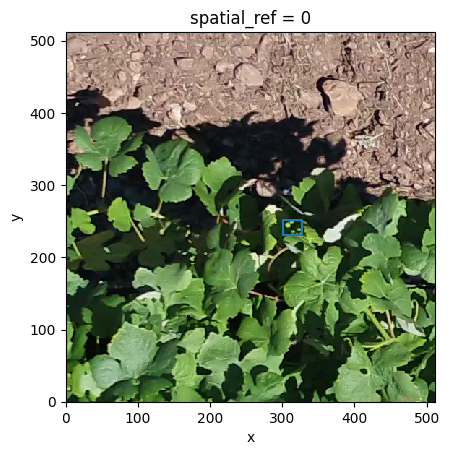

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

raster.plot.imshow(ax=ax)
tdf.boundary.plot(ax=ax)

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

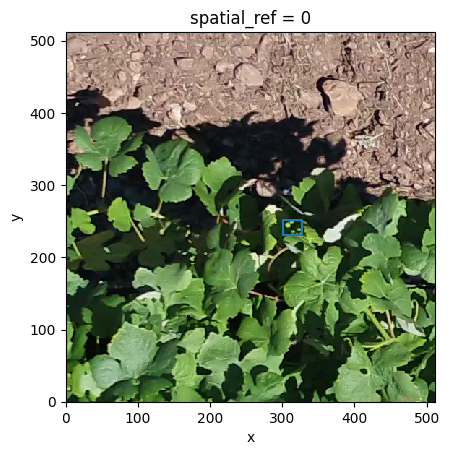

In [47]:
## AFFINE TRANSFORMATION TIME! BOOOOOOOoooooooooohoooooo
# Convert to 0-512 coordinates for every images and every label.
# something with .transform values to figure out!
tf = raster.rio.transform()

tdf.geometry = tdf.translate(xoff = -1 * tf.xoff, yoff = -1 * tf.yoff)
r = raster.assign_coords(x= (raster.x+tf.xoff*-1), y= (raster.y+tf.yoff*-1))


import matplotlib.pyplot as plt
fig, ax = plt.subplots()

r.plot.imshow(ax=ax)
tdf.boundary.plot(ax=ax)


In [4]:
def convert_to_yolo_batch(boxes, img_width, img_height):
    # Calculate widths and heights
    widths = boxes[:, 2] - boxes[:, 0]
    heights = boxes[:, 3] - boxes[:, 1]

    # Calculate center points
    cx = (boxes[:, 0] + boxes[:, 2]) / 2
    cy = (boxes[:, 1] + boxes[:, 3]) / 2

    # Normalize values 
    normalized_cx = cx / img_width
    normalized_cy = cy / img_height
    normalized_w = widths / img_width
    normalized_h = heights / img_height

    # Create YOLO tensors
    yolo_tensors = torch.stack([normalized_cx, normalized_cy, normalized_w, normalized_h], dim=1)
    return yolo_tensors

In [5]:
import torch
boxs = tdf.geometry.bounds
boxs = torch.tensor(boxs.values)
convert_to_yolo_batch(boxs, raster.shape[2], raster.shape[1])

tensor([[0.6016, 0.9727, 0.0547, 0.0430]], dtype=torch.float64)

In [10]:
tdf

2    POLYGON ((322.000 487.000, 322.000 509.000, 29...
dtype: geometry

In [14]:
from rasterio import Affine
tf = raster.rio.transform()

raster = raster.rio.transform_bounds(trans)

type: CRS is invalid: None

In [37]:
tdf.affine_transform([tf.a, tf.b, tf.d,tf.e,tf.xoff,tf.yoff])

2    POLYGON ((3394.000 2023.000, 3394.000 2045.000...
dtype: geometry

In [41]:
tdf.translate(xoff = -1 * tf.xoff, yoff = -1 * tf.yoff)

2    POLYGON ((322.000 487.000, 322.000 509.000, 29...
dtype: geometry

In [12]:
from rasterio import Affine